No subsidy:  21.344773930462715
18.97822858382369
28.804038562962873
Normal subsidy:  21.005620638512365
18.69196125949983
28.22208560928051
50% subsidy:  20.537266092485694
18.296639716385933
27.418436292290572


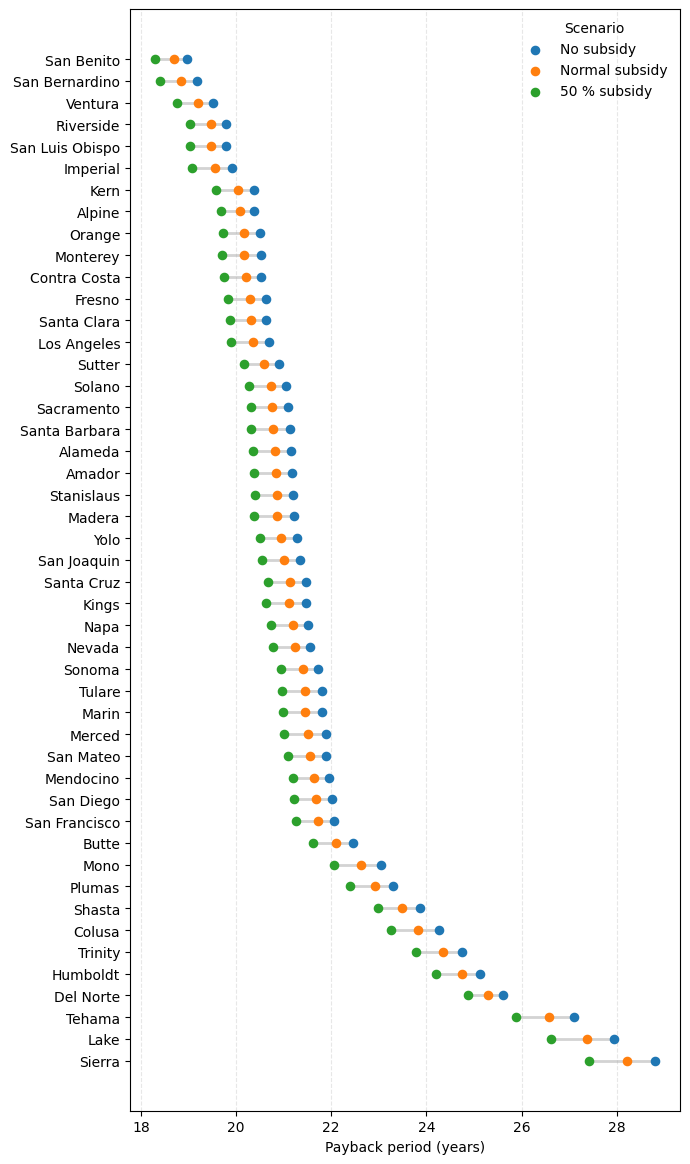

In [ ]:
# payback_dumbbell_fixed.py
# -------------------------------------------------------------
# Compare payback periods for 3 incentive scenarios.
# -------------------------------------------------------------
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
from pathlib import Path

BASE_DIR = Path(
    "../data/loadprofiles/induction_stove/single-family-detached/RESULTS/geojson"
)

FILES = {
    "No subsidy"     : "induction_stove_0_subsidies.geojson",
    "Normal subsidy" : "induction_stove_normal_subsidies.geojson",
    "50 % subsidy"   : "induction_stove_50_subsidies.geojson",
}

METRIC_COL = "Payback Period (Electrification + Solar + Storage)"  # column to compare

# ---------- 2) load, align, de-duplicate ----------
dfs = []
for label, fname in FILES.items():
    gdf = (
        gpd.read_file(BASE_DIR / fname)[["NAME", METRIC_COL]]
        .rename(columns={METRIC_COL: label})
    )
    dfs.append(gdf)

# merge on county name (inner join keeps only counties present in all 3)
df = dfs[0]
for extra in dfs[1:]:
    df = df.merge(extra, on="NAME", how="inner")

# some TIGER/GeoJSON files contain multiple geometries for the same county
# → collapse duplicates by *taking the first* (or use .mean() / .median()).
df = (
    df.groupby("NAME", as_index=False)
      .first()                    # keep the first geometry's values
      .dropna()                   # drop counties that still have missing numbers
      .sort_values("No subsidy")  # order rows (baseline column)
      .reset_index(drop=True)
)

# --------- 2.5) metrics ----------
print("No subsidy: ", df["No subsidy"].median())
print(df["No subsidy"].min())
print(df["No subsidy"].max())
print("Normal subsidy: ", df["Normal subsidy"].median())
print(df["Normal subsidy"].min())
print(df["Normal subsidy"].max())
print("50% subsidy: ", df["50 % subsidy"].median())
print(df["50 % subsidy"].min())
print(df["50 % subsidy"].max())

# ---------- 3) plotting ----------
scenarios = list(FILES.keys())
colour_map = {
    "No subsidy"    : "#1f77b4",  # blue
    "Normal subsidy": "#ff7f0e",  # orange
    "50 % subsidy"  : "#2ca02c",  # green
}

fig_h = max(5, 0.25 * len(df))       # stretch vertically if many counties
fig, ax = plt.subplots(figsize=(7, fig_h))

# (a) horizontal “stem” lines for each county
for y, (_, row) in enumerate(df.iterrows()):
    ax.hlines(
        y,
        xmin=row[scenarios].min(),
        xmax=row[scenarios].max(),
        color="lightgray",
        linewidth=2,
        zorder=1,
    )

# (b) scatter dots – *one call per scenario* so colour is consistent
for scen in scenarios:
    ax.scatter(
        df[scen],
        df.index,
        label=scen,
        color=colour_map[scen],
        s=35,
        zorder=2,
    )

# ---------- 4) cosmetics ----------
ax.set_xlabel("Payback period (years)")
ax.set_yticks(df.index)
ax.set_yticklabels(df["NAME"])
ax.invert_yaxis()                       # top-to-bottom alphabet feels natural
ax.grid(axis="x", linestyle="--", alpha=0.3)
ax.legend(title="Scenario", frameon=False, loc="upper right")

plt.tight_layout()
plt.show()